In [38]:
#import findspark
#findspark.init()
import pyspark
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql import Row
import pyspark.sql.functions as func
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .master("local[2]") \
    .appName("COM6012 Assignment 1 Task2") \
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

sc = spark.sparkContext

sc.setCheckpointDir('checkpoint/')


In [2]:
lines = spark.read.text("ml-25m/ratings.csv").rdd
parts = lines.map(lambda row: row.value.split(","))

header = parts.first()
parts = parts.filter(lambda line: line != header)

In [3]:
ratingsRDD = parts.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),rating=float(p[2]), timestamp=int(p[3])))
ratings = spark.createDataFrame(ratingsRDD).cache()

In [4]:
(fold_0, fold_1, fold_2) = ratings.randomSplit([1.0, 1.0, 1.0],seed=1234)

data_list = [fold_0,fold_1,fold_2]
test_list = [fold_2,fold_0,fold_1]

In [5]:
als_1 = ALS(rank=10,maxIter=10, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
als_2 = ALS(rank=25, maxIter=50, regParam=0.05, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
als_3 = ALS(rank=50,maxIter=100, regParam=0.005, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")

In [6]:
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating",predictionCol="prediction")

In [7]:
def cross_validate(als_version):
    dfItemFactors_list = []
    rmse_list =[]
    mae_list =[]
    fold_j = 0
    for fold_i in range(len(data_list)):
        if fold_j < len(data_list)-1:
            fold_j+= 1
        else:
            fold_j = 0
        first_train = data_list[fold_i].union(data_list[fold_j])
        model = als_version.fit(first_train)
        predictions = model.transform(test_list[fold_i])
        
        rmse = rmse_evaluator.evaluate(predictions)
        mae = mae_evaluator.evaluate(predictions)
        
        rmse_list.append(rmse)
        mae_list.append(mae)
    
    return rmse_list, mae_list

In [8]:
rmse_als_1, mae_als_1 = cross_validate(als_1)

In [9]:
rmse_als_2, mae_als_2 = cross_validate(als_2)

In [10]:
rmse_als_3, mae_als_3 = cross_validate(als_3)

In [11]:
import statistics as stat

In [12]:
#for calculate std and mean for rmse metric
als1_rmse_std,als1_rmse_mean = stat.stdev(rmse_als_1),stat.mean(rmse_als_1)
als2_rmse_std,als2_rmse_mean = stat.stdev(rmse_als_2),stat.mean(rmse_als_2)
als3_rmse_std,als3_rmse_mean = stat.stdev(rmse_als_3),stat.mean(rmse_als_3)

#for calculate std and mean for mae metric
als1_mae_std,als1_mae_mean = stat.stdev(mae_als_1),stat.mean(mae_als_1)
als2_mae_std,als2_mae_mean = stat.stdev(mae_als_2),stat.mean(mae_als_2)
als3_mae_std,als3_mae_mean = stat.stdev(mae_als_3),stat.mean(mae_als_3)

In [20]:
rdd_report = sc.parallelize([(rmse_als_1[0],mae_als_1[0],rmse_als_2[0],mae_als_2[0],rmse_als_3[0],mae_als_3[0]),
                            (rmse_als_1[1],mae_als_1[1],rmse_als_2[1],mae_als_2[1],rmse_als_3[1],mae_als_3[1]),
                            (rmse_als_1[2],mae_als_1[2],rmse_als_2[2],mae_als_2[2],rmse_als_3[2],mae_als_3[2]),
                            (als1_rmse_std,als1_mae_std,als2_rmse_std,als2_mae_std,als3_rmse_std,als3_mae_std),
                            (als1_rmse_mean,als1_mae_mean,als2_rmse_mean,als2_mae_mean,als3_rmse_mean,als3_mae_mean)])

In [21]:
df_report = rdd_report.toDF(['ALS Version 1 RMSE Result','ALS Version 1 MAE Result'
                             ,'ALS Version 2 RMSE Result','ALS Version 2 MAE Result'
                            ,'ALS Version 3 RMSE Result','ALS Version 3 MAE Result'])

In [22]:
df_pd = df_report.toPandas()

In [26]:
df_report.printSchema()

root
 |-- ALS Version 1 RMSE Result: double (nullable = true)
 |-- ALS Version 1 MAE Result: double (nullable = true)
 |-- ALS Version 2 RMSE Result: double (nullable = true)
 |-- ALS Version 2 MAE Result: double (nullable = true)
 |-- ALS Version 3 RMSE Result: double (nullable = true)
 |-- ALS Version 3 MAE Result: double (nullable = true)



In [16]:
df_pd.index = ['Fold1','Fold2','Fold3','Std','Mean']

In [17]:
print(df_pd)

       ALS Version 1 RMSE Result  ALS Version 1 MAE Result  \
Fold1                   0.805640                  0.621416   
Fold2                   0.805427                  0.621305   
Fold3                   0.805112                  0.620761   
Std                     0.000265                  0.000350   
Mean                    0.805393                  0.621161   

       ALS Version 2 RMSE Result  ALS Version 2 MAE Result  \
Fold1                   0.774958                  0.590067   
Fold2                   0.775099                  0.590257   
Fold3                   0.774690                  0.589771   
Std                     0.000208                  0.000245   
Mean                    0.774916                  0.590032   

       ALS Version 3 RMSE Result  ALS Version 3 MAE Result  
Fold1                   0.910658                  0.674270  
Fold2                   0.910426                  0.674408  
Fold3                   0.910633                  0.674151  
Std       

In [36]:
df_pd

,ALS Version 1 RMSE Result,ALS Version 1 MAE Result,ALS Version 2 RMSE Result,ALS Version 2 MAE Result,ALS Version 3 RMSE Result,ALS Version 3 MAE Result
0,0.805640,0.621416,0.774958,0.590067,0.910658,0.674270
1,0.805427,0.621305,0.775099,0.590257,0.910426,0.674408
2,0.805112,0.620761,0.774690,0.589771,0.910633,0.674151
3,0.000265,0.000350,0.000208,0.000245,0.000127,0.000129
4,0.805393,0.621161,0.774916,0.590032,0.910572,0.674276


<BarContainer object of 6 artists>

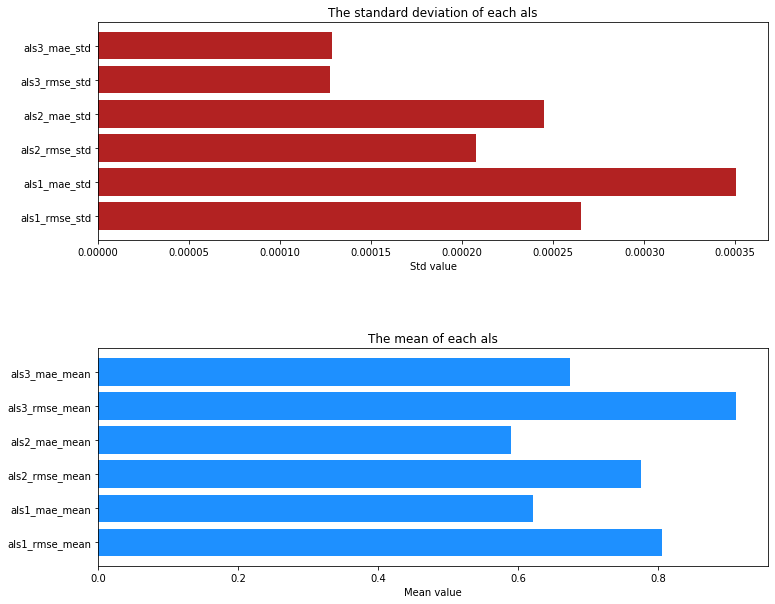

In [77]:
std_list=[als1_rmse_std,als1_mae_std,als2_rmse_std,als2_mae_std,als3_rmse_std,als3_mae_std]
mean_list =[als1_rmse_mean,als1_mae_mean,als2_rmse_mean,als2_mae_mean,als3_rmse_mean,als3_mae_mean]

x = np.arange(6)
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.yticks(np.arange(6), ('als1_rmse_std','als1_mae_std','als2_rmse_std','als2_mae_std','als3_rmse_std','als3_mae_std'))
plt.title("The standard deviation of each als")
plt.xlabel("Std value")
plt.barh(np.array(x),np.array(std_list),color=['firebrick'])
plt.subplots_adjust(hspace = 0.5)

plt.subplot(212)
plt.yticks(np.arange(6), ('als1_rmse_mean','als1_mae_mean','als2_rmse_mean','als2_mae_mean','als3_rmse_mean','als3_mae_mean'))
plt.title("The mean of each als")
plt.xlabel("Mean value")
plt.barh(np.array(x),np.array(mean_list),color=['dodgerblue'])